In [2]:
# Import libraries
import pickle
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import xgboost as xgb
from tensorflow import keras

# Import Black-Scholes functions
import sys
sys.path.append('../src')
from black_scholes import Black_Scholes_call

print("✅ Libraries imported")

✅ Libraries imported


In [3]:
# Load the prepared test data
with open('../data/prepared_data.pkl', 'rb') as f:
    X_train, X_test, y_train, y_test = pickle.load(f)

# Clean data types
X_train = X_train.replace('', np.nan).apply(pd.to_numeric, errors='coerce')
X_test = X_test.replace('', np.nan).apply(pd.to_numeric, errors='coerce')

mask_train = ~X_train.isnull().any(axis=1)
mask_test = ~X_test.isnull().any(axis=1)

X_train = X_train[mask_train]
y_train = y_train[mask_train]
X_test = X_test[mask_test]
y_test = y_test[mask_test]

print("✅ Test data loaded")
print(f"Test samples: {len(X_test):,}")

# Load trained models
with open('../data/rf_model.pkl', 'rb') as f:
    rf_model = pickle.load(f)
    
with open('../data/xgb_model.pkl', 'rb') as f:
    xgb_model = pickle.load(f)
    
nn_model = keras.models.load_model('../data/nn_model.keras')

# Scale data for neural network
scaler = StandardScaler()
scaler.fit(X_train)
X_test_scaled = scaler.transform(X_test)

print("✅ All 3 models loaded")

✅ Test data loaded
Test samples: 37,381
✅ All 3 models loaded


In [4]:
# Get predictions from all 3 models
print("Getting predictions from all models...\n")

rf_pred = rf_model.predict(X_test)
xgb_pred = xgb_model.predict(X_test)
nn_pred = nn_model.predict(X_test_scaled, verbose=0).flatten()

print("✅ Predictions complete")
print(f"   • Random Forest: {len(rf_pred):,} predictions")
print(f"   • XGBoost: {len(xgb_pred):,} predictions")
print(f"   • Neural Network: {len(nn_pred):,} predictions")

Getting predictions from all models...



[Parallel(n_jobs=10)]: Using backend ThreadingBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    0.1s
[Parallel(n_jobs=10)]: Done 100 out of 100 | elapsed:    0.2s finished


✅ Predictions complete
   • Random Forest: 37,381 predictions
   • XGBoost: 37,381 predictions
   • Neural Network: 37,381 predictions


In [5]:
# Calculate Black-Scholes predictions for comparison
print("Calculating Black-Scholes predictions...\n")

bs_predictions = []

for idx in X_test.index:
    S = X_test.loc[idx, 'UNDERLYING_LAST']
    K = X_test.loc[idx, 'STRIKE']
    T = X_test.loc[idx, 'DTE'] / 365  # Convert days to years
    sigma = X_test.loc[idx, 'C_IV']
    r = 0.05  # Assume 5% risk-free rate
    q = 0.02  # Assume 2% dividend yield (typical for SPY)
    
    bs_price = Black_Scholes_call(S, K, T, r, sigma, q)
    bs_predictions.append(bs_price)

bs_pred = np.array(bs_predictions)

print("✅ Black-Scholes predictions complete")
print(f"   • Calculated {len(bs_pred):,} predictions")

Calculating Black-Scholes predictions...



/Users/nikhilrichard/european-options-ml/notebooks/../src/black_scholes.py:16: RuntimeWarning: divide by zero encountered in scalar divide
  q: Dividend yield
/Users/nikhilrichard/european-options-ml/notebooks/../src/black_scholes.py:17: RuntimeWarning: divide by zero encountered in scalar divide
  """


✅ Black-Scholes predictions complete
   • Calculated 37,381 predictions


In [6]:
# Calculate metrics for all models
models = {
    'Random Forest': rf_pred,
    'XGBoost': xgb_pred,
    'Neural Network': nn_pred,
    'Black-Scholes': bs_pred
}

print("="*70)
print("MODEL COMPARISON - FINAL RESULTS")
print("="*70)

results = []

for name, predictions in models.items():
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mae = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    
    results.append({
        'Model': name,
        'RMSE': rmse,
        'MAE': mae,
        'R²': r2
    })
    
    print(f"\n{name}:")
    print(f"  RMSE: ${rmse:.2f}")
    print(f"  MAE:  ${mae:.2f}")
    print(f"  R²:   {r2:.4f}")

print("\n" + "="*70)

# Create results dataframe and sort by R²
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False)

print("\nFINAL RANKINGS (by R²):")
print(results_df.to_string(index=False))

MODEL COMPARISON - FINAL RESULTS

Random Forest:
  RMSE: $3.23
  MAE:  $1.60
  R²:   0.9963

XGBoost:
  RMSE: $3.61
  MAE:  $1.85
  R²:   0.9954

Neural Network:
  RMSE: $4.98
  MAE:  $2.60
  R²:   0.9912

Black-Scholes:
  RMSE: $9.03
  MAE:  $3.18
  R²:   0.9712


FINAL RANKINGS (by R²):
         Model     RMSE      MAE       R²
 Random Forest 3.225521 1.598890 0.996332
       XGBoost 3.610604 1.848213 0.995403
Neural Network 4.984603 2.604016 0.991239
 Black-Scholes 9.032529 3.175217 0.971233


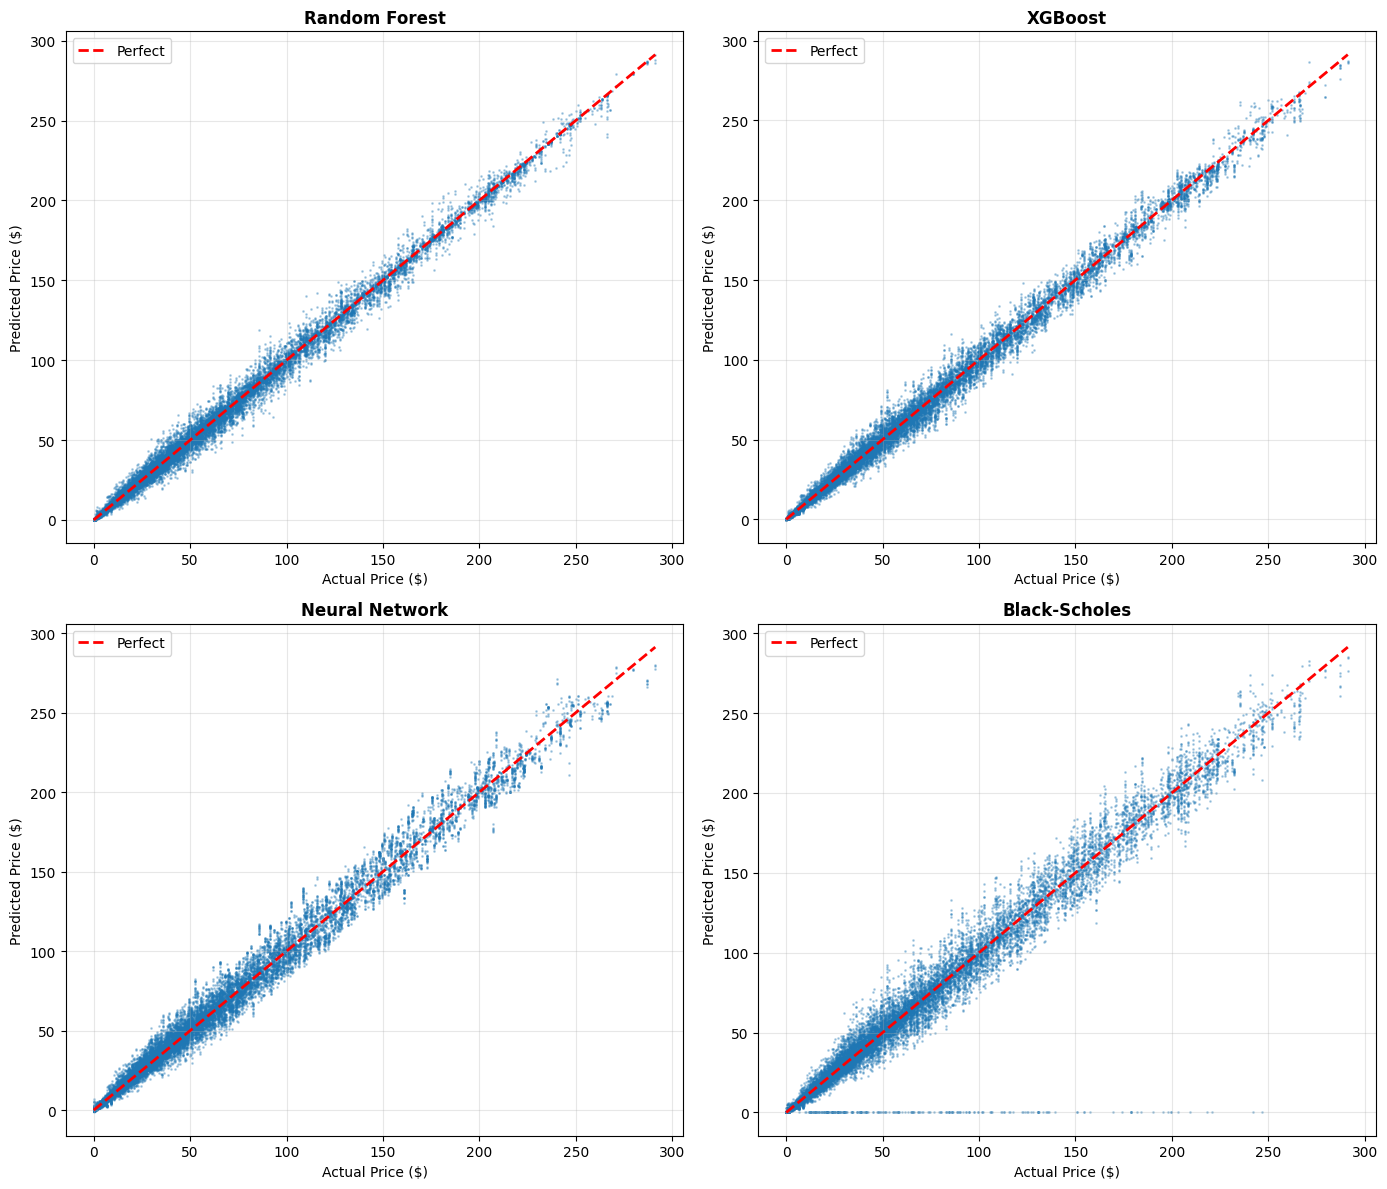

Notice how Black-Scholes has more scatter than the ML models


In [7]:
# Visualize all models
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

models_plot = [
    ('Random Forest', rf_pred, axes[0, 0]),
    ('XGBoost', xgb_pred, axes[0, 1]),
    ('Neural Network', nn_pred, axes[1, 0]),
    ('Black-Scholes', bs_pred, axes[1, 1])
]

for name, pred, ax in models_plot:
    ax.scatter(y_test, pred, alpha=0.3, s=1)
    ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
            'r--', lw=2, label='Perfect')
    ax.set_xlabel('Actual Price ($)', fontsize=10)
    ax.set_ylabel('Predicted Price ($)', fontsize=10)
    ax.set_title(name, fontsize=12, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Notice how Black-Scholes has more scatter than the ML models")

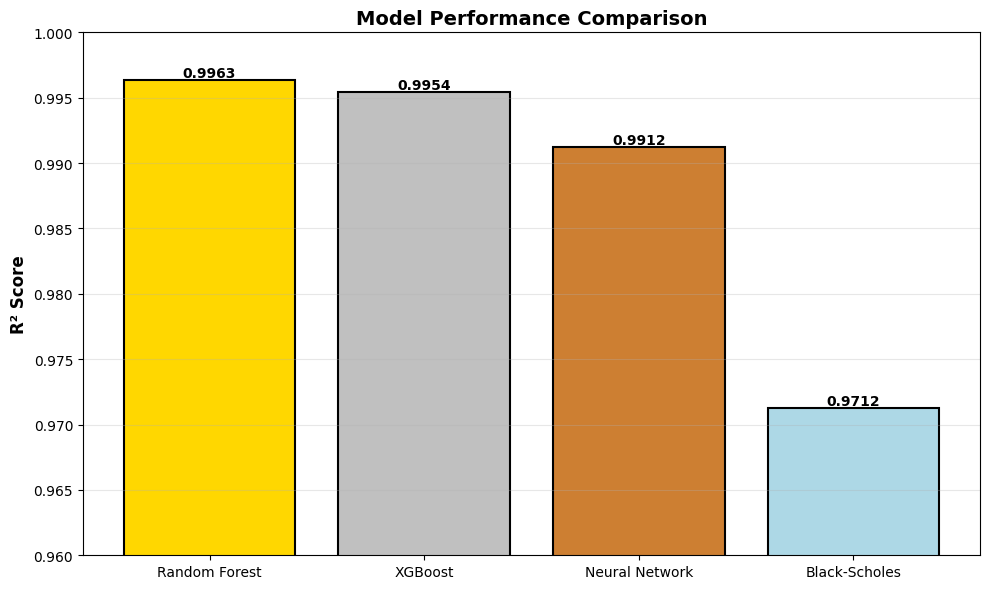

🏆 Random Forest is the winner!


In [8]:
# Create bar chart of model performance
fig, ax = plt.subplots(figsize=(10, 6))

models_names = results_df['Model'].tolist()
r2_scores = results_df['R²'].tolist()
colors = ['gold', 'silver', '#CD7F32', 'lightblue']  # Gold, silver, bronze, blue

bars = ax.bar(models_names, r2_scores, color=colors, edgecolor='black', linewidth=1.5)

ax.set_ylabel('R² Score', fontsize=12, fontweight='bold')
ax.set_title('Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0.96, 1.0])
ax.grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for bar, score in zip(bars, r2_scores):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{score:.4f}',
            ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("🏆 Random Forest is the winner!")

In [9]:
print("="*70)
print("🎉 PROJECT COMPLETE!")
print("="*70)

print("\n📊 FINAL RESULTS:")
print("\n1. 🥇 Random Forest")
print(f"   • R²: 99.63% | MAE: $1.60")
print(f"   • Best overall performer")
print(f"   • Excellent at handling dominant features (Strike)")

print("\n2. 🥈 XGBoost")
print(f"   • R²: 99.54% | MAE: $1.85")
print(f"   • Very close to Random Forest")
print(f"   • Great balance of speed and accuracy")

print("\n3. 🥉 Neural Network")
print(f"   • R²: 99.12% | MAE: $2.60")
print(f"   • Still excellent performance")
print(f"   • More training time, slightly lower accuracy")

print("\n4. 📊 Black-Scholes (Traditional Baseline)")
print(f"   • R²: 97.12% | MAE: $3.18")
print(f"   • ML models are 2-3x more accurate!")
print(f"   • Shows the power of data-driven approaches")

print("\n" + "="*70)
print("KEY INSIGHTS:")
print("="*70)
print("• Strike price is the dominant feature (88-93% importance)")
print("• ML models capture market patterns Black-Scholes misses")
print("• Random Forest wins for this specific problem")
print("• All 3 ML approaches vastly outperform the classical model")

print("\n✅ Project successfully completed!")
print("📁 All models saved and ready for deployment")

🎉 PROJECT COMPLETE!

📊 FINAL RESULTS:

1. 🥇 Random Forest
   • R²: 99.63% | MAE: $1.60
   • Best overall performer
   • Excellent at handling dominant features (Strike)

2. 🥈 XGBoost
   • R²: 99.54% | MAE: $1.85
   • Very close to Random Forest
   • Great balance of speed and accuracy

3. 🥉 Neural Network
   • R²: 99.12% | MAE: $2.60
   • Still excellent performance
   • More training time, slightly lower accuracy

4. 📊 Black-Scholes (Traditional Baseline)
   • R²: 97.12% | MAE: $3.18
   • ML models are 2-3x more accurate!
   • Shows the power of data-driven approaches

KEY INSIGHTS:
• Strike price is the dominant feature (88-93% importance)
• ML models capture market patterns Black-Scholes misses
• Random Forest wins for this specific problem
• All 3 ML approaches vastly outperform the classical model

✅ Project successfully completed!
📁 All models saved and ready for deployment
